In [1]:
!jupyter nbconvert --to python seqInit.ipynb

[NbConvertApp] Converting notebook seqInit.ipynb to python
[NbConvertApp] Writing 1936 bytes to seqInit.py


---
### FC模型

In [3]:
# 引入torch相关模块
import torch
from torch import nn, optim
from torch.autograd import Variable
from torch.nn import init

# 引入初始化文件中的相关内容
from seqInit import toTs, cudAvl
from seqInit import input_size, trainX, trainY
from seqInit import test, result

# 引入画图工具
import numpy as np
import matplotlib.pyplot as plt

In [4]:
# 定义FC模型

class fcModel(nn.Module) :
    def __init__(self, in_dim, hidden_dim, out_dim) :
        super().__init__()
        ly, self.linear = 1, nn.Sequential()
        for hid in hidden_dim :
            layer = nn.Sequential(nn.Linear(in_dim, hid), nn.ReLU(True))
            self.linear.add_module('layer_{}'.format(ly), layer)
            ly, in_dim = ly + 1, hid
        self.linear.add_module('layer_{}'.format(ly), nn.Linear(in_dim, out_dim))
    
    def forward(self, x) :
        x = self.linear(x)
        return x

# 输入为3，输出为1，设定为3层，分别有[20, 10, 5]的维度
hidden = [20, 10, 5]
fc = cudAvl(fcModel(input_size, hidden, 1))

# 使用kaiming_normal初始化模型参数

for name, param in fc.named_parameters() :
    if 'weight' in name :
        init.kaiming_normal(param)

# 定义损失函数和优化函数
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(fc.parameters(), lr = 1e-2)    

In [5]:
# 处理输入
fcx = trainX.reshape(-1, 3)
fcx = torch.from_numpy(fcx)
fcy = trainY.reshape(-1, 1)
fcy = torch.from_numpy(fcy)
print(fcx.shape, fcy.shape)

torch.Size([117, 3]) torch.Size([117, 1])


Epoch[10/100], Loss: 238.99052
Epoch[20/100], Loss: 199.59294
Epoch[30/100], Loss: 221.17123
Epoch[40/100], Loss: 213.66656
Epoch[50/100], Loss: 187.46429
Epoch[60/100], Loss: 134.03819
Epoch[70/100], Loss: 129.84370
Epoch[80/100], Loss: 156.95114
Epoch[90/100], Loss: 109.49894
Epoch[100/100], Loss: 113.44046


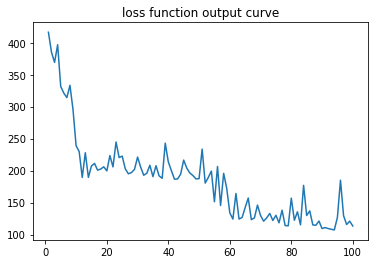

CPU times: user 2min 18s, sys: 4.21 s, total: 2min 22s
Wall time: 2min 17s


In [6]:
%%time
# 训练FC模型
frq_out, sec = 5000, 100
loss_set = []
for e in range(frq_out * sec) :
    inputs = cudAvl(Variable(fcx))
    target = cudAvl(Variable(fcy))
    # forward
    outputs = fc(inputs)
    loss = criterion(outputs, target)
    # reset gradients
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    # print training infomation
    print_loss = loss.data[0]
    if (e + 1) % frq_out == 0 :
        current = (e + 1) // frq_out
        loss_set.append((current, print_loss))
        if current % 10 == 0 :
            print('Epoch[{}/{}], Loss: {:.5f}'.format(current, sec, print_loss))

# 作出损失函数变化图像
pltX = np.array([loss[0] for loss in loss_set])
pltY = np.array([loss[1] for loss in loss_set])
plt.title('loss function output curve')
plt.plot(pltX, pltY)
plt.show()

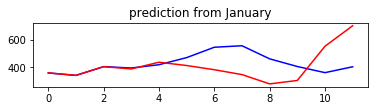

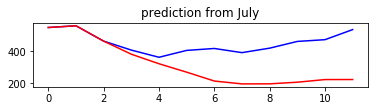

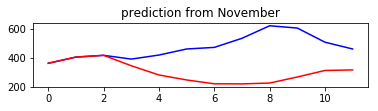

average MSE = 32895.33373149104


In [7]:
fc = fc.eval()

# 预测结果并比较

# 定义预测函数
def predict(model, x, t = 12) :
    predlist = x.reshape(-1).tolist()
    x = toTs(x.reshape(-1, 3))
    for i in range(12) :
        varX = cudAvl(Variable(x, volatile=True))
        y = model(varX).data[0, 0]
        predlist.append(y)
        x[0, 0] = x[0, 1]
        x[0, 1] = x[0, 2]
        x[0, 2] = y
    return np.array(predlist)

subplotloc, subplotTitle = [311, 312, 313], ['January', 'July', 'November']
allMse = 0.0
for i in range(3) :
    # numpy转化为Tensor后引用的是原来的array数组，需要备份一份操作
    predlist = predict(fc, test[i, :, :].copy())[:12]
    plt.subplot(subplotloc[i])
    plt.title('prediction from {}'.format(subplotTitle[i]))
    plt.plot(result[i], 'b', label='real')
    plt.plot(predlist, 'r', label='pred')
    plt.show()
    mse = sum((predlist - result[i]) ** 2) / 12
    allMse += mse
allMse /= 3
print('average MSE =', allMse)

---
**可以发现，FC模型误差极大。300个参数左右需要训练*2min 17s***